## Neural Network Method for Black Hole Imaging

### Import libraries and modules

In [1]:
import sys
import csv
import os
import numpy as np
import pandas as pd
import random
from numpy.random import randint
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from PIL import Image

from keras.callbacks import ModelCheckpoint
from keras.initializers import RandomUniform, Constant
import keras.models
from keras.models import Sequential
import keras.layers
from keras.layers import Layer, Activation, LeakyReLU
from keras.layers import Input, InputLayer, AveragePooling2D, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Sequential, Model, load_model
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate, Add
from keras.layers import Dense, Lambda, Reshape
import keras.initializers
import keras.regularizers
import keras.callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras import losses
from keras.datasets import fashion_mnist
from keras.datasets import mnist

# Import eht imaging package
!pip3 install ehtim
import ehtim as eh 
import ehtim.const_def as ehc
import ehtim.observing.obs_helpers as obsh
from ehtim.observing.obs_helpers import *

# Import helpers from cosense
import helpers_posci as hp

# Import utilities for computing data terms, losses, and gradients
import helpers_posci as hp
from models_posci import IsingVisNet
from layers_posci import _unet_from_tensor, Ising_sampling, Ising_sampling2, Site_mask_prob
from layers_posci import realnvp_encoder, realnvp_decoder, Lambda_Gaussian, Lambda_logdet_sigmoid, STE_layer, Gaussian_sampling


Using TensorFlow backend.


Welcome to eht-imaging! v  1.1.1


### Define Imaging Variables

In [2]:
'''Define observation parameters.'''
eht_array='EHT2019'
target='sgrA'

nsamp = 10000
npix = 32 
fov_param = 100.0
flux_label = 1
sefd_param = 1

tint_sec = 5    # integration time in seconds
tadv_sec = 600  # advance time between scans
tstart_hr = 0   # GMST time of the start of the observation
tstop_hr = 24   # GMST time of the end
bw_hz = 4e9     # bandwidth in Hz

stabilize_scan_phase = False # if true then add a single phase error for each scan to act similar to adhoc phasing
stabilize_scan_amp = False # if true then add a single gain error at each scan
jones = False # apply jones matrix for including noise in the measurements (including leakage)
inv_jones = False # no not invert the jones matrix
frcal = True # True if you do not include effects of field rotation
dcal = True # True if you do not include the effects of leakage
dterm_offset = 0 # a random offset of the D terms is given at each site with this standard deviation away from 1
dtermp = 0

array = '/Users/Johanna/Desktop/Proximal Gradient Descent/arrays/' + eht_array + '.txt'
eht = eh.array.load_txt(array)

# Define observation field of view
fov = fov_param * eh.RADPERUAS

# define scientific target
if target == 'm87':
    ra = 12.513728717168174
    dec = 12.39112323919932
elif target == 'sgrA':
    ra = 19.414182210498385
    dec = -29.24170032236311

rf = 230e9
mjd = 57853 # day of observation
fwhm = 1.117609542559987e-10

### Define Helper Functions

In [3]:
''' 
    Prepare and return dataset. Fashion MNIST and Digits MNIST images are blurred by 0.1*fwhm.
    
    -----------------------------------------------------------------------------------------------------
    Parameters:
        -dataset: 'fashion' (fashion MNIST, 'mnist' (MNIST digits), or 'bh_data' (simulated black hole images)
        -flux: sum of pixels per image
    ----------------------------------------------------------------------------------------------------------
    
'''
def get_data(dataset='fashion', flux=1):
    xdata = []
    pad_width = 2
    if (dataset == 'fashion' or dataset == 'all'):
        npix = 32
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

        xdata = 1.0*x_train[[k%60000 for k in range(int(nsamp))]]
        xdata = np.pad(xdata, ((0,0), (pad_width,pad_width), (pad_width,pad_width)), 'constant')
        xdata = xdata[..., np.newaxis]/255
        
        xdata = xdata.reshape((-1, npix*npix))
        
        # Blur images by 0.1*fwhm
        xdata_blur = []
        for X in xdata:
            pred_blur = eh.image.make_empty(npix, fov, ra, dec, rf=rf, source='random', mjd=mjd)
            pred_blur.imvec = X.flatten()
            pred_blur = pred_blur.blur_circ(fwhm_i=0.1*fwhm, fwhm_pol=0.1*fwhm)
            xdata_blur.append(pred_blur.imvec)
        xdata = xdata_blur
            
    if (dataset == 'mnist' or dataset == 'all'):
        npix = 32
        (x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()
        
        xdata_train = 1.0*x_train_mnist[[k%60000 for k in range(int(nsamp))]]
        xdata_train = np.pad(xdata_train, ((0,0), (pad_width,pad_width), (pad_width,pad_width)), 'constant')  # get to 160x160
        xdata_train = xdata_train[..., np.newaxis]/255
        
        xdata = xdata_train.reshape((-1, npix*npix))
        
        # Blur images by 0.1*fwhm
        xdata_blur = []
        for X in xdata:
            pred_blur = eh.image.make_empty(npix, fov, ra, dec, rf=rf, source='random', mjd=mjd)
            pred_blur.imvec = X.flatten()
            pred_blur = pred_blur.blur_circ(fwhm_i=0.1*fwhm, fwhm_pol=0.1*fwhm)
            xdata_blur.append(pred_blur.imvec)
        xdata = xdata_blur
        
    if (dataset == 'bh_data'):
        # Download at https://www.dropbox.com/s/kv0x5eolg10w52g/bh_sim_data.npy?dl=0
        bh_sim_data = np.load('bh_sim_data.npy', allow_pickle=True).item()
        bh_data = bh_sim_data['image']
        
        # resize images to 32 x 32 and fov = 100
        bh_data = np.array(bh_data)
        bh_data_reshape = []
        for i in range(len(bh_data)):
            bh_img = eh.image.make_empty(160, 160, ra, dec, rf=rf, source='random', mjd=mjd)
            bh_img.imvec = bh_data[i].flatten()
            bh_img_reshape = bh_img.regrid_image(100, 32)
            bh_data_reshape.append(bh_img_reshape.imvec)
        xdata = np.array(bh_data_reshape).reshape((-1, 32*32))
    
    return xdata

'''
    Generate measurement data for image X using specified parameters. 
    
    -----------------------------------------------------------------------------------------------------
    Parameters:
        -X: target image
        -th_noise: If True, include thermal noise in measurements
        -amp_error: If True, include amplitude error in measurements
        -phase_error: If True, include phase error in measurements
        -gainp: Amount of site-wise standard deviation in gain error to include in measurements
        -gain_offset: Amount of fixed gain error to include in measurements
    -----------------------------------------------------------------------------------------------------
'''
def get_measurements(X, th_noise=False, amp_error=False, phase_error=False, gainp=0.1, gain_offset=0.1):
    # Define noise parameters
    add_th_noise = th_noise # False if you *don't* want to add thermal error. If there are no sefds in obs_orig it will use the sigma for each data point
    phasecal = not phase_error # True if you don't want to add atmospheric phase error. if False then it adds random phases to simulate atmosphere
    ampcal = not amp_error # True if you don't want to add atmospheric amplitude error. if False then add random gain errors 

    simim = eh.image.make_empty(npix, fov, ra, dec, rf=rf, source='random', mjd=mjd)
    simim.imvec = X
    
    # generate the discrete Fourier transform matrices for complex visibilities
    obs = simim.observe(eht, tint_sec, tadv_sec, tstart_hr, tstop_hr, bw_hz, add_th_noise=add_th_noise, ampcal=ampcal, phasecal=phasecal, 
                    stabilize_scan_phase=stabilize_scan_phase, stabilize_scan_amp=stabilize_scan_amp,
                    jones=jones,inv_jones=inv_jones,dcal=dcal, frcal=frcal, dterm_offset=dterm_offset, 
                    gainp=gainp, gain_offset=gain_offset)
    obs_data = obs.unpack(['u', 'v', 'vis', 'sigma'])
    
    uv = np.hstack((obs_data['u'].reshape(-1,1), obs_data['v'].reshape(-1,1)))
    
    # Extract forward model (Discrete Fourier Transform matrix)
    F_vis = ftmatrix(simim.psize, simim.xdim, simim.ydim, uv, pulse=simim.pulse)
    vis = obs_data['vis']
    sigma = obs_data['sigma']
    
    if th_noise:
        sigma = 224.46 * np.concatenate([np.expand_dims(obs.data['sigma'], -1), np.expand_dims(obs.data['sigma'], -1)], -1)
    else:
        sigma = None
        
    t1 = obs.data['t1']
    t2 = obs.data['t2']
    
    print("Finished computing visibilities...")
    
    # generate the discrete Fourier transform matrices for closure phases
    obs.add_cphase(count='max')
    # Extract forward models for telescopes 1, 2, and 3
    tc1 = obs.cphase['t1']
    tc2 = obs.cphase['t2']
    tc3 = obs.cphase['t3']
    
    cphase = obs.cphase['cphase']
    sigma_cphase = obs.cphase['sigmacp']
    cphase_map = np.zeros((len(obs.cphase['time']), 3))

    zero_symbol = 10000
    for k1 in range(cphase_map.shape[0]):
        for k2 in list(np.where(obs.data['time']==obs.cphase['time'][k1])[0]):
            if obs.data['t1'][k2] == obs.cphase['t1'][k1] and obs.data['t2'][k2] == obs.cphase['t2'][k1]:
                cphase_map[k1, 0] = k2
                if k2 == 0:
                    cphase_map[k1, 0] = zero_symbol
            elif obs.data['t2'][k2] == obs.cphase['t1'][k1] and obs.data['t1'][k2] == obs.cphase['t2'][k1]:
                cphase_map[k1, 0] = -k2
                if k2 == 0:
                    cphase_map[k1, 0] = -zero_symbol
            elif obs.data['t1'][k2] == obs.cphase['t2'][k1] and obs.data['t2'][k2] == obs.cphase['t3'][k1]:
                cphase_map[k1, 1] = k2
                if k2 == 0:
                    cphase_map[k1, 1] = zero_symbol
            elif obs.data['t2'][k2] == obs.cphase['t2'][k1] and obs.data['t1'][k2] == obs.cphase['t3'][k1]:
                cphase_map[k1, 1] = -k2
                if k2 == 0:
                    cphase_map[k1, 1] = -zero_symbol
            elif obs.data['t1'][k2] == obs.cphase['t3'][k1] and obs.data['t2'][k2] == obs.cphase['t1'][k1]:
                cphase_map[k1, 2] = k2
                if k2 == 0:
                    cphase_map[k1, 2] = zero_symbol
            elif obs.data['t2'][k2] == obs.cphase['t3'][k1] and obs.data['t1'][k2] == obs.cphase['t1'][k1]:
                cphase_map[k1, 2] = -k2
                if k2 == 0:
                    cphase_map[k1, 2] = -zero_symbol

    F_cphase = np.zeros((cphase_map.shape[0], npix*npix, 3), dtype=np.complex64)
    cphase_proj = np.zeros((cphase_map.shape[0], F_vis.shape[0]), dtype=np.float32)
    for k in range(cphase_map.shape[0]):
        for j in range(cphase_map.shape[1]):
            if cphase_map[k][j] > 0:
                if int(cphase_map[k][j]) == zero_symbol:
                    cphase_map[k][j] = 0
                F_cphase[k, :, j] = F_vis[int(cphase_map[k][j]), :]
                cphase_proj[k, int(cphase_map[k][j])] = 1
            else:
                if np.abs(int(cphase_map[k][j])) == zero_symbol:
                    cphase_map[k][j] = 0
                F_cphase[k, :, j] = np.conj(F_vis[int(-cphase_map[k][j]), :])
                cphase_proj[k, int(-cphase_map[k][j])] = -1
                
    clamparr = obs.c_amplitudes(mode='all', count='max',
                                        vtype='vis', ctype='camp', debias=True, snrcut=0.0)

    uv1 = np.hstack((clamparr['u1'].reshape(-1, 1), clamparr['v1'].reshape(-1, 1)))
    uv2 = np.hstack((clamparr['u2'].reshape(-1, 1), clamparr['v2'].reshape(-1, 1)))
    uv3 = np.hstack((clamparr['u3'].reshape(-1, 1), clamparr['v3'].reshape(-1, 1)))
    uv4 = np.hstack((clamparr['u4'].reshape(-1, 1), clamparr['v4'].reshape(-1, 1)))
    camp = clamparr['camp']
    sigma_camp = clamparr['sigmaca']
    
    mask = []
    # shape: (4, 2022, npix**2)
    F_camp = (ftmatrix(simim.psize, simim.xdim, simim.ydim, uv1, pulse=simim.pulse, mask=mask),
          ftmatrix(simim.psize, simim.xdim, simim.ydim, uv2, pulse=simim.pulse, mask=mask),
          ftmatrix(simim.psize, simim.xdim, simim.ydim, uv3, pulse=simim.pulse, mask=mask),
          ftmatrix(simim.psize, simim.xdim, simim.ydim, uv4, pulse=simim.pulse, mask=mask)
          )
    
    return obs, vis, F_vis, sigma, t1, t2

# Post process predicted image by normalizing flux to that of the target image.
def post_process(Z, img):
    flux, X_max = np.sum(img), np.max(img)

    # Normalize flux to target image
    Z_flux = np.sum(np.abs(Z))
    Z = (flux/Z_flux)*np.abs(Z)

    # Normalize Z between 0 and X_max
    Z = np.maximum(np.zeros(np.shape(Z)), Z)
    Z = np.minimum(X_max*np.ones(np.shape(Z)), Z)
    
    return Z

# Compute chi-squared loss between true and predicted image
def chisq_loss(x_true, pred_vis):
    print('HERE')
    # compute true visibility
    true_vis = keras.layers.Lambda(hp.Lambda_dft(global_F))(x_true)
    
    # compute chisq loss
    num = tf.reduce_sum(tf.square(tf.divide(tf.abs(tf.subtract(pred_vis, true_vis)), global_S)))
    chisq = tf.divide(num, tf.cast(tf.multiply(2, tf.size(true_vis[0])), tf.float32))
    
    return chisq

# Compute normalized cross-correlation between images X and Z
def compute_xcorr(X, Z):
    target_img = eh.image.make_empty(npix, fov, ra, dec, rf=rf, source='random', mjd=mjd)
    target_img.imvec = X.flatten()
    recon_img = eh.image.make_empty(npix, fov, ra, dec, rf=rf, source='random', mjd=mjd)
    recon_img.imvec = Z.flatten()
    xc = target_img.compare_images(recon_img)[0][0] 
    return xc
    
# Compute MAE loss 
from sklearn.metrics import mean_absolute_error
def compute_mae(X, Z):
    mae = mean_absolute_error(X.flatten(), Z.flatten())
    return mae

''' Show results '''
def visualize(target, pred, obs):
    max_color = 0.01
    if dataset == 'fashion':
        max_color = 0.005
    
    # Compute nominally blurred target image
    fwhm = obs.res()
    target_blur = eh.image.make_empty(npix, fov, ra, dec, rf=rf, source='random', mjd=mjd)
    target_blur.imvec = target.flatten()
    target_blur1 = target_blur.blur_circ(fwhm_i=0.3*fwhm, fwhm_pol=0.3*fwhm)
    target_blur2 = target_blur.blur_circ(fwhm_i=0.7*fwhm, fwhm_pol=0.7*fwhm)
    
    # Show nominally blurred target image
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 3), ncols=3)

    ground_truth = ax1.imshow((target).reshape(npix, npix), vmin=0, vmax=max_color)
    ax1.title.set_text('Ground Truth')
    fig.colorbar(ground_truth, ax=ax1)
    blur1 = ax2.imshow(target_blur1.imvec.reshape(npix, npix), vmin=0, vmax=max_color)
    ax2.title.set_text('0.3 * fwhm Blurred Truth')
    fig.colorbar(blur1, ax=ax2)
    blur2 = ax3.imshow(target_blur2.imvec.reshape(npix, npix), vmin=0, vmax=max_color)
    ax3.title.set_text('0.7 * fwhm Blurred Truth')
    cbar = fig.colorbar(blur2, ax=ax3)
    cbar.minorticks_on()
    plt.show()
    
    # Compute nominally blurred predicted image
    fwhm = obs.res()
    pred_blur = eh.image.make_empty(npix, fov, ra, dec, rf=rf, source='random', mjd=mjd)
    pred_blur.imvec = pred.flatten()
    pred_blur1 = pred_blur.blur_circ(fwhm_i=0.3*fwhm, fwhm_pol=0.3*fwhm)
    pred_blur2 = pred_blur.blur_circ(fwhm_i=0.7*fwhm, fwhm_pol=0.7*fwhm)
    
    # Visualize blurred results
    fig3, (ax7, ax8, ax9) = plt.subplots(figsize=(13, 3), ncols=3)

    pred_img = ax7.imshow(pred.reshape(npix, npix), vmin=0, vmax=max_color)
    ax7.title.set_text('Predicted Image')
    fig3.colorbar(pred_img, ax=ax7)
    blur1_img = ax8.imshow(pred_blur1.imvec.reshape(npix, npix), vmin=0, vmax=max_color)
    ax8.title.set_text('0.3 * fwhm blur')
    fig3.colorbar(blur1_img, ax=ax8)
    blur2_img = ax9.imshow(pred_blur2.imvec.reshape(npix, npix), vmin=0, vmax=max_color)
    ax9.title.set_text('0.7 * fwhm blur')
    fig3.colorbar(blur2_img, ax=ax9)
    cbar.minorticks_on()
    plt.show()

### Load dataset 

In [5]:
# Select dataset: 'fashion' for Fashion MNIST, 'digits' for MNIST digits, or 'bh_data' for black hole simulated images
print('Loading dataset...')
dataset = 'fashion'
xdata = get_data(dataset)
print('Done.')

Loading dataset...
Done.


### Select target image and generate observations

In [6]:
# Select target image at index 0
target = xdata[0]

# Normalize target images
target /= np.sum(target)

obs, visibility, F_vis, sigma, t1, t2 = get_measurements(target.flatten())  # data terms
fwhm = obs.res()
print("Done.")

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 49/106 

/Users/Johanna/opt/anaconda3/lib/python3.7/site-packages/ehtim/obsdata.py:486: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(datalist)


Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Done.


### Load Pre-Trained Model

Pre-trained model can be downloaded at https://www.dropbox.com/s/fszl68xkdr6hdt6/pretrained_model?dl=0.

In [8]:
print("Loading pre-trainend model...")
model = IsingVisNet(t1, t2, F_vis, n_ising_layers=3, slope_const=3, obs_prob=1)
model.load_weights('pretrained_model')

# Remove input image layer, replace with direct complex visibility input
print("Replacing input layer...")
vis_input = keras.layers.Input(shape=(1691,2), name="vis")

filt = 64
kern = 3
acti = None
F = F_vis

vis_reshape = keras.layers.Reshape((2*F.shape[0], ))(vis_input)
dirty_im = keras.layers.Dense(32*32*1, activation=acti, use_bias=True, kernel_initializer=RandomUniform(minval=-5e-4, maxval=5e-4, seed=None), name='dense_dirtyimage')(vis_reshape)
dirty_im_reshape = keras.layers.Reshape((32, 32, 1))(dirty_im)
pred_img = _unet_from_tensor(dirty_im_reshape, filt, kern, acti)
pred_img = keras.layers.ReLU(name='recon')(pred_img)
pred_vis = keras.layers.Lambda(hp.Lambda_dft(F), name='pred_vis')(pred_img)

# Model returns predicted image and predicted visibilities
vis_model = keras.models.Model(inputs=vis_input, outputs=[pred_img, pred_vis])

print("Copying shared layer weights to vis_model...")
for i in range(1, len(vis_model.layers)-1):
    vis_model.layers[i].set_weights(model.layers[i+1].get_weights())
    
opt = keras.optimizers.Adam(learning_rate=0.001)
vis_model.compile(optimizer=opt, loss='mae')

print(vis_model.summary())

Loading pre-trainend model...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Replacing input layer...
Copying shared layer weights to vis_model...
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
vis (InputLayer)                (None, 1691, 2)      0                                            
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 3382)         0           vis[0][0]                        
__________________________________________________________________________________________________
dense_dirtyimage (Dense)        (None, 1024)         3464192     reshape_3[0][0]                  
__________________________________________________________________________________________________
reshape_4

### Define Noise Parameters

In [9]:
npix = 32
flux = 1            # image flux
th_noise = False    # add thermal noise
phase_err = False   # add phase noise
amp_err = False     # add amplitude noise
gainp=0.0           # std of site-specific gain error 
gain_offset=0.1     # fixed offset of site-specific gain error

### Generate Prediction with Model

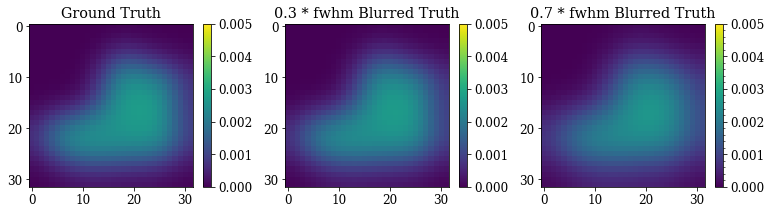

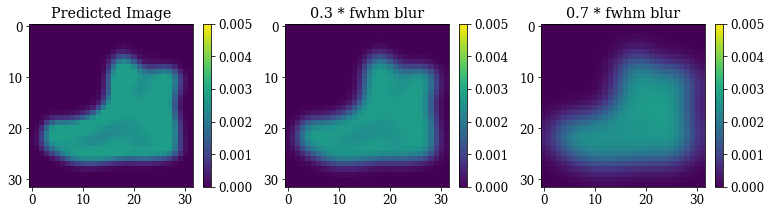

MAE =  0.00021775
Chi^2 =  34.5336289


In [13]:
vis_split = np.column_stack((np.real(visibility), np.imag(visibility)))
vis_split = np.float32(224.46*vis_split.reshape((1, 1691,2)))
[pred_img, pred_vis] = vis_model.predict(vis_split, steps=1)

# Normalize predicted image by constant 
# (used for training neural network to prevent dying weights during back propagation)
ALPHA = 500
pred_img /= ALPHA

# Normalize predicted image flux to target image flux
pred_img = post_process(pred_img, target)

# Apply blur by 0.5*fwhm to target image
target_blur = eh.image.make_empty(npix, fov, ra, dec, rf=rf, source='random', mjd=mjd)
target_blur.imvec = target.flatten()
target_blur = target_blur.blur_circ(fwhm_i=0.5*fwhm, fwhm_pol=0.5*fwhm)
target = target_blur.imvec

# Apply blur by 0.5*fwhm to predicted image
fwhm = obs.res()
pred_blur = eh.image.make_empty(npix, fov, ra, dec, rf=rf, source='random', mjd=mjd)
pred_blur.imvec = pred_img.flatten()
pred_blur_img = pred_blur.blur_circ(fwhm_i=0.5*fwhm, fwhm_pol=0.5*fwhm)
pred_blur = pred_blur_img.imvec

mae = np.mean(np.abs((np.subtract(pred_blur.flatten(), target.flatten()))))
chisq = obs.chisq(pred_blur_img,dtype='vis') 

visualize(target, pred_img, obs)

print("MAE = ", np.round(mae, 8))
print("Chi^2 = ", np.round(chisq, 8))